In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import scipy.io as sp
import matplotlib.transforms as transforms

# Load Data

In [2]:
mean_tab = pd.read_csv("mean_tab.csv", index_col = "Unnamed: 0")

In [3]:
mean_tab["pred"].unique()

array(['A', 'B', 'C', '¬A', '¬B', '¬C', 'B|A', 'B|¬A', '¬B|A', '¬B|¬A',
       'A ∩ B', 'A ∩ ¬B', '¬A ∩ B', '¬A ∩ ¬B', 'A ∪ B', 'A ∪ ¬B',
       '¬A ∪ B', '¬A ∪ ¬B', 'C|B', 'C|¬B', '¬C|B', '¬C|¬B', 'B ∩ C',
       'B ∩ ¬C', '¬B ∩ C', '¬B ∩ ¬C', 'B ∪ C', 'B ∪ ¬C', '¬B ∪ C',
       '¬B ∪ ¬C', 'A|C', 'A|¬C', '¬A|C', '¬A|¬C', 'C ∩ A', 'C ∩ ¬A',
       '¬C ∩ A', '¬C ∩ ¬A', 'C ∪ A', 'C ∪ ¬A', '¬C ∪ A', '¬C ∪ ¬A', 'A|B',
       '¬A|B', 'A|¬B', '¬A|¬B', 'B ∩ A', '¬B ∩ A', 'B ∩ ¬A', '¬B ∩ ¬A',
       'B ∪ A', '¬B ∪ A', 'B ∪ ¬A', '¬B ∪ ¬A', 'B|C', '¬B|C', 'B|¬C',
       '¬B|¬C', 'C ∩ B', '¬C ∩ B', 'C ∩ ¬B', '¬C ∩ ¬B', 'C ∪ B', '¬C ∪ B',
       'C ∪ ¬B', '¬C ∪ ¬B', 'C|A', '¬C|A', 'C|¬A', '¬C|¬A', 'A ∩ C',
       '¬A ∩ C', 'A ∩ ¬C', '¬A ∩ ¬C', 'A ∪ C', '¬A ∪ C', 'A ∪ ¬C',
       '¬A ∪ ¬C'], dtype=object)

## Compute Binary Complementarity

In [4]:
def negation(statement):
    statement = statement.replace(" ", "")
    if "∩" in statement:
        split_statements = statement.split("∩")
        neg_statement = "¬" + split_statements[1] + " ∪ " + "¬" + split_statements[0]
    elif "∪" in statement:
        split_statements = statement.split("∪")
        neg_statement = "¬" + split_statements[1] + " ∩ " + "¬" + split_statements[0]
    else:
        neg_statement = "¬" + statement
    neg_statement = neg_statement.replace("¬¬", "")
    return neg_statement

In [5]:
bin_comp_tab = {"subject":[], "rating":[], "type":[], "pred":[], "pair":[]}

In [6]:
for p in mean_tab["pair"].unique():
    print(p)
    pair_tab = mean_tab[mean_tab["pair"] == p]
    for m in pair_tab["type"].unique():
        print(m)
        model_tab = pair_tab[pair_tab["type"] == m]
        complete_list = []
        count = 1
        for s in model_tab["pred"].unique():
            neg_s = negation(s)
            if s not in complete_list and neg_s not in complete_list:
                s_tab = model_tab[model_tab["pred"] == s]
                neg_s_tab = model_tab[model_tab["pred"] == neg_s]
                for subj in s_tab["subject"].unique():
                    ps = np.array(s_tab[s_tab["subject"] == subj]["rating"])[0]
                    pnegs = np.array(neg_s_tab[neg_s_tab["subject"] == subj]["rating"])[0]
                    bin_comp_tab["subject"].append(subj)
                    bin_comp_tab["rating"].append(ps + pnegs)
                    bin_comp_tab["type"].append(m)
                    bin_comp_tab["pred"].append(s + " + " + neg_s)
                    bin_comp_tab["pair"].append(p)
                complete_list.append(s)
                complete_list.append(neg_s)

A1_A2
data
BS
QSS
CSS
RF
A1_A3
data
BS
QSS
CSS
RF
A2_A3
data
BS
QSS
CSS
RF
B1_B2
data
BS
QSS
CSS
RF
B1_B3
data
BS
QSS
CSS
RF
B2_B3
data
BS
QSS
CSS
RF


In [7]:
bin_comp_tab = pd.DataFrame(bin_comp_tab)
bin_comp_tab

,subject,rating,type,pred,pair
0,0,121.0,data,A + ¬A,A1_A2
1,1,111.0,data,A + ¬A,A1_A2
2,2,99.0,data,A + ¬A,A1_A2
3,3,110.0,data,A + ¬A,A1_A2
4,4,139.0,data,A + ¬A,A1_A2
...,...,...,...,...,...
244015,1157,100.0,RF,B|¬C + ¬B|¬C,B2_B3
244016,1158,100.0,RF,B|¬C + ¬B|¬C,B2_B3
244017,1159,100.0,RF,B|¬C + ¬B|¬C,B2_B3
244018,1160,100.0,RF,B|¬C + ¬B|¬C,B2_B3


In [8]:
bin_comp_tab.to_csv("bin_comp_tab.csv")

## Plot Binary Complementarity

In [9]:
bin_comp_plot_tab = {"tab":{}, "mean":{}}

In [10]:
for pair in bin_comp_tab["pair"].unique():
    bin_comp_plot_tab["tab"][pair] = {}
    bin_comp_plot_tab["mean"][pair] = {}
    for m in bin_comp_tab["type"].unique():
        model_tab = bin_comp_tab[bin_comp_tab["pair"] == pair]
        model_tab = model_tab[model_tab["type"] == m]
        bin_comp_plot_tab["tab"][pair][m] = model_tab
        bin_comps = []
        for p in model_tab['pred'].unique():
            pred_tab = model_tab[model_tab["pred"] == p]
            #Compute bin_comps
            bin_comps.append(np.mean(pred_tab["rating"]))
        bin_comp_plot_tab["mean"][pair][m] = bin_comps

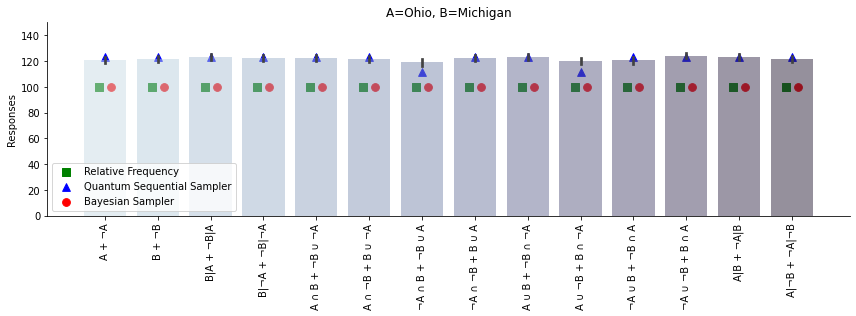

In [11]:
plt.rcParams["figure.figsize"] = (12,4.5)
offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData
ax = sns.barplot(x="pred", y="rating", data=bin_comp_plot_tab["tab"]["A1_A2"]["data"], alpha=0.5, palette = "ch:s=.25,rot=-.25", ci = 95)
plt.xticks(rotation = 90)
plt.ylim(0,150)
plt.title("A=Ohio, B=Michigan")
plt.scatter(bin_comp_plot_tab["tab"]["A1_A2"]["RF"]["pred"].unique(), bin_comp_plot_tab["mean"]["A1_A2"]["RF"], 
            marker = "s", color = "green", s = plt.rcParams['lines.markersize'] * 10, label = "Relative Frequency",
           transform=trans+offset(-6))
plt.scatter(bin_comp_plot_tab["tab"]["A1_A2"]["QSS"]["pred"].unique(), bin_comp_plot_tab["mean"]["A1_A2"]["QSS"], 
            marker = "^", color = "blue", s = plt.rcParams['lines.markersize'] * 10, label = "Quantum Sequential Sampler",
           transform=trans+offset(0))
plt.scatter(bin_comp_plot_tab["tab"]["A1_A2"]["BS"]["pred"].unique(), bin_comp_plot_tab["mean"]["A1_A2"]["BS"], 
            marker = "o", color = "red", s = plt.rcParams['lines.markersize'] * 10, label = "Bayesian Sampler",
           transform=trans+offset(6))
plt.legend()
plt.xlabel("")
plt.ylabel("Responses")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.subplots_adjust(bottom=0.22)
plt.tight_layout()
plt.savefig("bin_comp_A1_A2.jpg",dpi = 500)

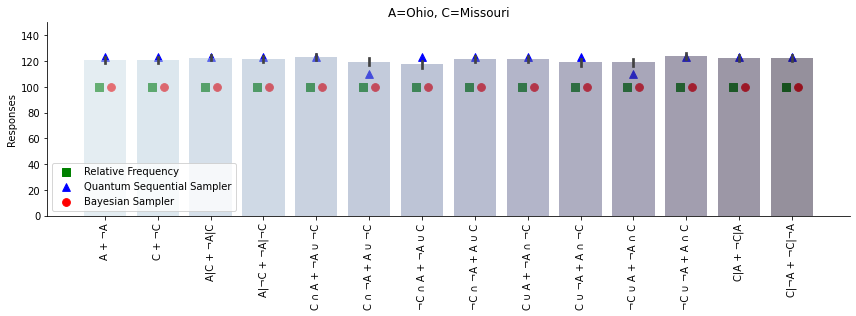

In [12]:
plt.rcParams["figure.figsize"] = (12,4.5)
offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData
ax = sns.barplot(x="pred", y="rating", data=bin_comp_plot_tab["tab"]["A1_A3"]["data"], alpha=0.5, palette = "ch:s=.25,rot=-.25", ci = 95)
plt.xticks(rotation = 90)
plt.ylim(0,150)
plt.title("A=Ohio, C=Missouri")
plt.scatter(bin_comp_plot_tab["tab"]["A1_A3"]["RF"]["pred"].unique(), bin_comp_plot_tab["mean"]["A1_A3"]["RF"], 
            marker = "s", color = "green", s = plt.rcParams['lines.markersize'] * 10, label = "Relative Frequency",
           transform=trans+offset(-6))
plt.scatter(bin_comp_plot_tab["tab"]["A1_A3"]["QSS"]["pred"].unique(), bin_comp_plot_tab["mean"]["A1_A3"]["QSS"], 
            marker = "^", color = "blue", s = plt.rcParams['lines.markersize'] * 10, label = "Quantum Sequential Sampler",
           transform=trans+offset(0))
plt.scatter(bin_comp_plot_tab["tab"]["A1_A3"]["BS"]["pred"].unique(), bin_comp_plot_tab["mean"]["A1_A3"]["BS"], 
            marker = "o", color = "red", s = plt.rcParams['lines.markersize'] * 10, label = "Bayesian Sampler",
           transform=trans+offset(6))
plt.legend()
plt.xlabel("")
plt.ylabel("Responses")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.subplots_adjust(bottom=0.22)
plt.tight_layout()
plt.savefig("bin_comp_A1_A3.jpg",dpi = 500)

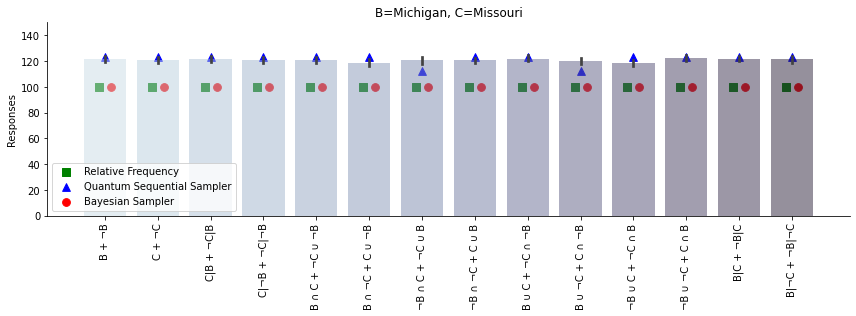

In [13]:
plt.rcParams["figure.figsize"] = (12,4.5)
offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData
ax = sns.barplot(x="pred", y="rating", data=bin_comp_plot_tab["tab"]["A2_A3"]["data"], alpha=0.5, palette = "ch:s=.25,rot=-.25", ci = 95)
plt.xticks(rotation = 90)
plt.ylim(0,150)
plt.title("B=Michigan, C=Missouri")
plt.scatter(bin_comp_plot_tab["tab"]["A2_A3"]["RF"]["pred"].unique(), bin_comp_plot_tab["mean"]["A2_A3"]["RF"], 
            marker = "s", color = "green", s = plt.rcParams['lines.markersize'] * 10, label = "Relative Frequency",
           transform=trans+offset(-6))
plt.scatter(bin_comp_plot_tab["tab"]["A2_A3"]["QSS"]["pred"].unique(), bin_comp_plot_tab["mean"]["A2_A3"]["QSS"], 
            marker = "^", color = "blue", s = plt.rcParams['lines.markersize'] * 10, label = "Quantum Sequential Sampler",
           transform=trans+offset(0))
plt.scatter(bin_comp_plot_tab["tab"]["A2_A3"]["BS"]["pred"].unique(), bin_comp_plot_tab["mean"]["A2_A3"]["BS"], 
            marker = "o", color = "red", s = plt.rcParams['lines.markersize'] * 10, label = "Bayesian Sampler",
           transform=trans+offset(6))
plt.legend()
plt.xlabel("")
plt.ylabel("Responses")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.subplots_adjust(bottom=0.22)
plt.tight_layout()
plt.savefig("bin_comp_A2_A3.jpg",dpi = 500)

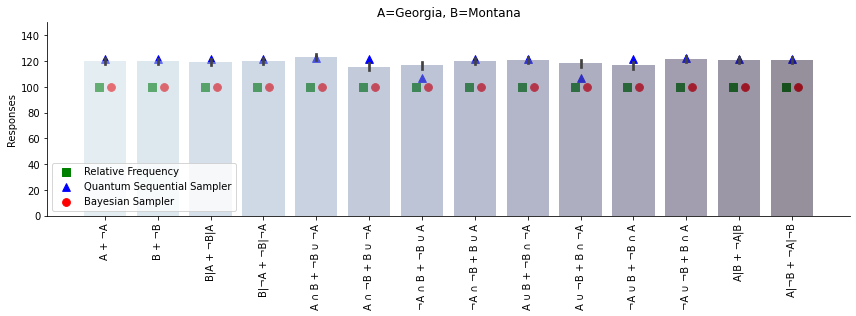

In [14]:
plt.rcParams["figure.figsize"] = (12,4.5)
offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData
ax = sns.barplot(x="pred", y="rating", data=bin_comp_plot_tab["tab"]["B1_B2"]["data"], alpha=0.5, palette = "ch:s=.25,rot=-.25", ci = 95)
plt.xticks(rotation = 90)
plt.ylim(0,150)
plt.title("A=Georgia, B=Montana")
plt.scatter(bin_comp_plot_tab["tab"]["B1_B2"]["RF"]["pred"].unique(), bin_comp_plot_tab["mean"]["B1_B2"]["RF"], 
            marker = "s", color = "green", s = plt.rcParams['lines.markersize'] * 10, label = "Relative Frequency",
           transform=trans+offset(-6))
plt.scatter(bin_comp_plot_tab["tab"]["B1_B2"]["QSS"]["pred"].unique(), bin_comp_plot_tab["mean"]["B1_B2"]["QSS"], 
            marker = "^", color = "blue", s = plt.rcParams['lines.markersize'] * 10, label = "Quantum Sequential Sampler",
           transform=trans+offset(0))
plt.scatter(bin_comp_plot_tab["tab"]["B1_B2"]["BS"]["pred"].unique(), bin_comp_plot_tab["mean"]["B1_B2"]["BS"], 
            marker = "o", color = "red", s = plt.rcParams['lines.markersize'] * 10, label = "Bayesian Sampler",
           transform=trans+offset(6))
plt.legend()
plt.xlabel("")
plt.ylabel("Responses")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.subplots_adjust(bottom=0.22)
plt.tight_layout()
plt.savefig("bin_comp_B1_B2.jpg",dpi = 500)

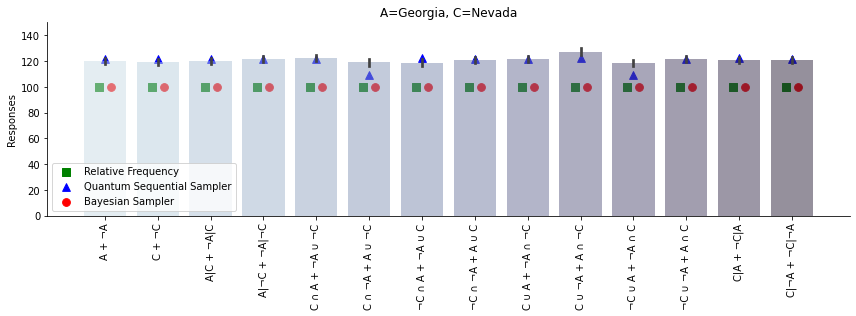

In [15]:
plt.rcParams["figure.figsize"] = (12,4.5)
offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData
ax = sns.barplot(x="pred", y="rating", data=bin_comp_plot_tab["tab"]["B1_B3"]["data"], alpha=0.5, palette = "ch:s=.25,rot=-.25", ci = 95)
plt.xticks(rotation = 90)
plt.ylim(0,150)
plt.title("A=Georgia, C=Nevada")
plt.scatter(bin_comp_plot_tab["tab"]["B1_B3"]["RF"]["pred"].unique(), bin_comp_plot_tab["mean"]["B1_B3"]["RF"], 
            marker = "s", color = "green", s = plt.rcParams['lines.markersize'] * 10, label = "Relative Frequency",
           transform=trans+offset(-6))
plt.scatter(bin_comp_plot_tab["tab"]["B1_B3"]["QSS"]["pred"].unique(), bin_comp_plot_tab["mean"]["B1_B3"]["QSS"], 
            marker = "^", color = "blue", s = plt.rcParams['lines.markersize'] * 10, label = "Quantum Sequential Sampler",
           transform=trans+offset(0))
plt.scatter(bin_comp_plot_tab["tab"]["B1_B3"]["BS"]["pred"].unique(), bin_comp_plot_tab["mean"]["B1_B3"]["BS"], 
            marker = "o", color = "red", s = plt.rcParams['lines.markersize'] * 10, label = "Bayesian Sampler",
           transform=trans+offset(6))
plt.legend()
plt.xlabel("")
plt.ylabel("Responses")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.subplots_adjust(bottom=0.22)
plt.tight_layout()
plt.savefig("bin_comp_B1_B3.jpg",dpi = 500)

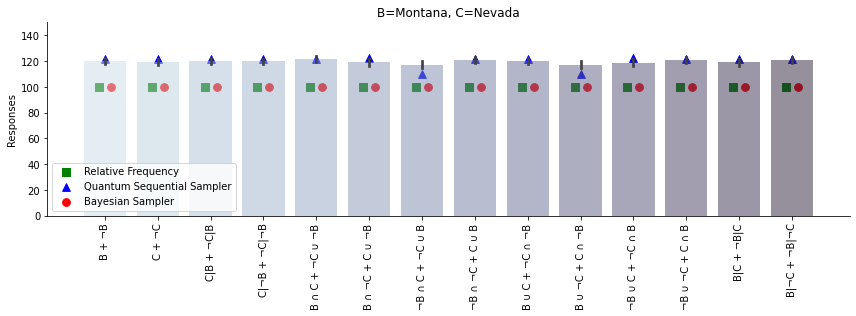

In [16]:
plt.rcParams["figure.figsize"] = (12,4.5)
offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData
ax = sns.barplot(x="pred", y="rating", data=bin_comp_plot_tab["tab"]["B2_B3"]["data"], alpha=0.5, palette = "ch:s=.25,rot=-.25", ci = 95)
plt.xticks(rotation = 90)
plt.ylim(0,150)
plt.title("B=Montana, C=Nevada")
plt.scatter(bin_comp_plot_tab["tab"]["B2_B3"]["RF"]["pred"].unique(), bin_comp_plot_tab["mean"]["B2_B3"]["RF"], 
            marker = "s", color = "green", s = plt.rcParams['lines.markersize'] * 10, label = "Relative Frequency",
           transform=trans+offset(-6))
plt.scatter(bin_comp_plot_tab["tab"]["B2_B3"]["QSS"]["pred"].unique(), bin_comp_plot_tab["mean"]["B2_B3"]["QSS"], 
            marker = "^", color = "blue", s = plt.rcParams['lines.markersize'] * 10, label = "Quantum Sequential Sampler",
           transform=trans+offset(0))
plt.scatter(bin_comp_plot_tab["tab"]["B2_B3"]["BS"]["pred"].unique(), bin_comp_plot_tab["mean"]["B2_B3"]["BS"], 
            marker = "o", color = "red", s = plt.rcParams['lines.markersize'] * 10, label = "Bayesian Sampler",
           transform=trans+offset(6))
plt.legend()
plt.xlabel("")
plt.ylabel("Responses")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.subplots_adjust(bottom=0.22)
plt.tight_layout()
plt.savefig("bin_comp_B2_B3.jpg",dpi = 500)